# Utilizing Cyclostationary Signal Processing Techniques. 
## Techniques used
1. Cyclic Autocorrelation Function (CAF)
2. Spectral Correlation Function (SCF)


## Can you accomplish the following...
1. Detect different modulation schemes?
    1. {2, 4, 8}-PSK, {16, 32, 64}-QPSK 
2. Detect the number of unique symbols sent?
3. Detect the length of the repeated symbols?
4. Is this detection sensitive to AWGN?



## Simplifications

1. No pulse shaping filter is used... Instead a simple repeated symbol scheme is used. 
    1. (**Not tested**) Justification... As long as the pulse shaping function that is utilized is a linearly time invariant filter, then the signals periodic properties are still intact. This should translate to similar results while speeding up computation as you can potentially target specific frequency bins.
    
    1. (**Support**) if $S(t)$ is periodic with period $T$,  $S(t) = S(t+k T) \quad k \in \mathbf{Z}$ and let $h$ be a LTI filter... $ h(t_1) = h(t_2) \quad \forall t_1,t_2 \in \mathbf{R}$, with, 
    the convolution denoted as $\circledast$  

 $$ \qquad
        (S \circledast h)(t) = \int_{-\infty}^{\infty}S(t)h(t-\tau) d{\tau}            \equiv  \qquad
        (S \circledast h)(t+kT) = \int_{-\infty}^{\infty}S(t+kT)h(t+kT-\tau) d{\tau}   
 $$
 
 By $h$ being LTI, and $S(t)$ having period $T$

# Simulated Data

In [1]:
# Imports
%matplotlib notebook 
# optional # %matplotlib inline
import numpy as np
from commpy import PSKModem, QAMModem
from commpy.filters import rectfilter, gaussianfilter, rrcosfilter, rcosfilter
from matplotlib import pyplot as plt
from matplotlib import pyplot  
from scipy.signal import find_peaks
import pandas as pd
import scipy.stats as st
from scipy import signal

from sklearn import mixture


In [4]:
#
# Set up the paramaters
##
nsymbols=2
repeats_per_symbol = 20
samples_per_second = 100
message_len = 3000
total_samples = repeats_per_symbol*message_len
baseband_carrier_freq = 20 # fc center frequency 
noise_sd = 0.01 # noise 



# calculate
## apply hamming_filter
h_filter = np.hamming(repeats_per_symbol)  # no idea if this is the right thing to convolve!
h_filter  = h_filter/np.sum(h_filter)
#
duration = total_samples//samples_per_second
time = np.linspace(0, duration, total_samples)/samples_per_second  # clock time of each sample
dt = duration/(total_samples*samples_per_second)

freqs = np.fft.ifftshift(np.fft.fftfreq(len(time), dt))
print(f" Set Fs: {1/dt} \n Set dt: {dt} \n Total_Samples: {len(time)}")

params = {
    'nsymbols':nsymbols,
    'repeats_per_symbol'   :  repeats_per_symbol,
    'samples_per_second'  :   samples_per_second,
    'message_len'   :   message_len ,
    'total_samples'  :  total_samples ,
    'baseband_carrier_freq' :   baseband_carrier_freq,
    'noise_sd'  :   noise_sd ,
    'duration' :  duration, 
    'time'  :   time, 
    'dt'  :   dt,
    'freqs'  :   freqs,
    "h_filter": h_filter
    }

 Set Fs: 10000.0 
 Set dt: 0.0001 
 Total_Samples: 60000


In [5]:
# Definition to get test data
def gen_df(modulation=2, params={}):
    print("generating df... ")
    # set params
    nsymbols =  params["nsymbols"]
    repeats_per_symbol = params["repeats_per_symbol"]
    samples_per_second = params["samples_per_second"]
    message_len = params["message_len"]
    total_samples = params["total_samples"]
    baseband_carrier_freq = params["baseband_carrier_freq"]
    noise_sd = params["noise_sd"]
    duration = params["duration"]
    time =  params["time"]
    dt = params["dt"]
    freqs = params["freqs"]
    h_filter = params["h_filter"]
    
    # define values...     
    baseband_signal =  np.exp(1j*2*np.pi*time*baseband_carrier_freq)
    baseband_inv = np.exp(-1j*2*np.pi*time*baseband_carrier_freq)
    
    # define constellation
    m = QAMModem(nsymbols)
    con = m.constellation
    con = con/np.max(np.abs(con))  # power normablizing
    
    # set message
    symbol_message = np.random.randint(0, nsymbols, message_len)
    message_with_repeats = np.repeat(symbol_message, repeats_per_symbol)
    
    # Pulse shapeing with hamming filter
    # better repeat scheme
    #
    pad_message = np.zeros(len(symbol_message)*repeats_per_symbol, dtype=complex)
    indexes = np.arange(len(symbol_message))*repeats_per_symbol
    pad_message[indexes] = con[symbol_message]
    

    # print(np.sum(hamming_filter))
    
    # Note I didnt use the pad message here instead I convolved the iq_encoded message  I was curious what the difference in the spectrogram would be
    smooth_iq_encoded_message = signal.fftconvolve(pad_message, h_filter, mode="same")
    
    # An IQ encoding of a message is just a symbol lookup table
    iq_encoded_message = con[message_with_repeats]
    iq_encoded_message
    
    # Modulate the encoding unto the baseband cf
    modulated = iq_encoded_message*baseband_signal
    smooth_modulated = smooth_iq_encoded_message*baseband_signal
    noise = np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) + \
        1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
    
    # Channel refers to the idea of a channel model with experimental effects.  Here AWGN.
    channel_iq = modulated + noise
    smooth_channel_iq = smooth_modulated + noise
    
    # Unmodulate with baseband inv to get the original modulation with noise effects
    unmodulated = channel_iq*baseband_inv
    
    data = {
        "modulated": modulated,
        "unmodulated":unmodulated,
        "channel_iq": channel_iq,
        "iq_encoded_message": iq_encoded_message,
        "baseband_signal": baseband_signal,
        "baseband_inv": baseband_inv,
        "noise_vec":noise,
        "smooth_channel_iq": smooth_channel_iq,
        "smooth_modulated": modulated,
        "smooth_iq_encoded_message": smooth_iq_encoded_message
        }
    
    df = pd.DataFrame(data)
    return params, df
    
    
params, df = gen_df(modulation=2, params=params)  

print("columns", [col for col in df.columns.values])
# optional prints... 

# print(df.describe())
# print(df.info())

generating df... 
columns ['modulated', 'unmodulated', 'channel_iq', 'iq_encoded_message', 'baseband_signal', 'baseband_inv', 'noise_vec', 'smooth_channel_iq', 'smooth_modulated', 'smooth_iq_encoded_message']


In [7]:
## Helper functions
def get_iq(df_s):
    """
    transform a df series of complex vals
    into the dataFrame of real and imaginary columns.
    Return: pandas.DataFrame
    """    
    dfc = {
        "i": (df_s.values).real,
        "q": (df_s.values).imag
    }
    
    return pd.DataFrame(dfc)

def detect_freq_range(f_caf, alpha=0.95):
    """
    View lagged correlation of signal to determine
    a frequency responce and filter out the decaying harmonics...
    Input: fft({lagged correlation function})
    
    """    
    #y = np.where(np.log(np.abs(f_caf)) > 0, np.log(np.abs(f_caf)), np.nan)
    y = np.log(np.abs(f_caf))
    peaks_caf =  find_peaks(y)[0]
    
    #create 95% confidence interval for population mean weight
    lb, ub = st.t.interval(alpha=alpha,
                  df=len(peaks_caf)-1,
                  loc=np.mean(peaks_caf),
                  scale=st.sem(peaks_caf)) 
    
    return lb, ub, peaks_caf, y

def pplot(df_s, df):
    """
    df_s is a dataframe series containing complex values for a scatter plot
    df is the full data frame so I can access the noise levels for coloring
    """
    df_iq = get_iq(df_s)
    color_ = 1 - np.abs(df["noise_vec"])/np.max(np.abs(df["noise_vec"]))
    df_iq["complement_noise_lvl"] = color_
    plt.close("all")
    df_iq.plot.scatter(x="i", y="q",c="complement_noise_lvl", colormap='viridis', alpha=color_ )
    plt.title(df_s.name)
    plt.show()

<IPython.core.display.Javascript object>


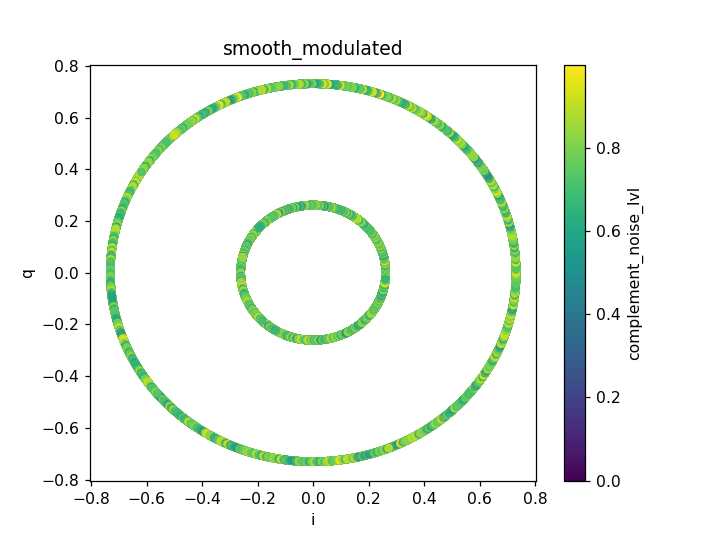

In [8]:
# defint input data... and plot iq 
select = 'smooth_modulated'

x = np.asarray(df[select])
pplot(df[select], df)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   smooth_iq_encoded_message  60000 non-null  float64
 1   noise_vec                  60000 non-null  float64
dtypes: float64(2)
memory usage: 937.6 KB
None


<IPython.core.display.Javascript object>


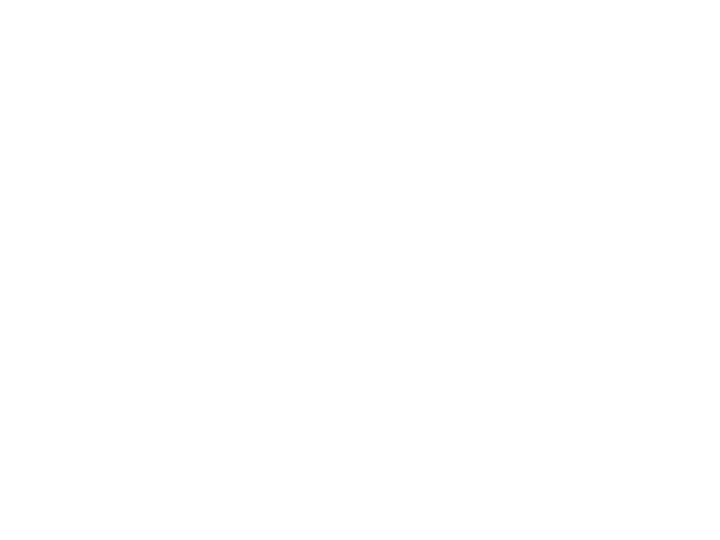

In [9]:
# Plotting the psd
df_s = pd.DataFrame()
f = lambda x:  pd.DataFrame(2*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x))))/len(x))

df_s["smooth_iq_encoded_message"] = f(df["smooth_iq_encoded_message"])
#df_s[select] = f(df[select])
df_s["noise_vec"] =  f(df["noise_vec"])
print(df_s.info())
plt.close("all")
df_s.plot.line()
plt.show()

# Cycle Autocorrelation Function (CAF)

1. First calculate the asymetric CAF $\hat{R}_{\tau}^{\alpha}$
2. Place in the frequency domain, apply a shift of $-\pi \alpha \tau $ to all freqs alpha and calculate the symmetric CAF

<IPython.core.display.Javascript object>


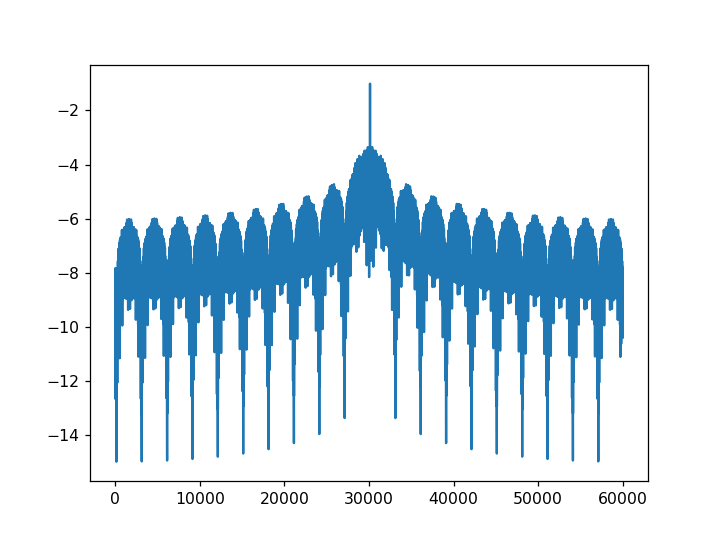

In [10]:
# Calculate the Asymetric CAF
# first calculate the asymetric Spectral Correlation Function,
# apply a shift to the Asym_SCF and inverse fft to get the Symmetric CAF value.

def filter_once(x, freqs):
    """ I need to remove the oscilating harmonics because it is messing everything up...
        This is no longer necessary as the pulse shaping function should adjust
        and my cyclostationary analysis should be fine.
        ... returning x instead of the filtered version, x[Taus] 
    """
    auto_cor = signal.correlate(x,
                           x,
                           mode="same")/len(x)

    conj_auto_cor = signal.correlate(x,
                           np.conj(x),
                           mode="same")/len(x)

    lags = signal.correlation_lags(x.size, x.size, mode="same")

    a_cor = auto_cor[lags]
    c_cor = conj_auto_cor[lags]

    """
    view auto_correlation as an 
    fft, and extrapulate the frequency range
    with the highest periodic components.
    """
    
    asym_scf = np.fft.fftshift(np.fft.fft(auto_cor))   
    conj_asym_scf = np.fft.fftshift(np.fft.fft(conj_auto_cor))

    # filter potential alpha values down to only those that describe
    # the periodic components within the autocorrelate function.
    lb, ub, peaks, y = detect_freq_range(asym_scf, alpha=0.99)
    Taus = lags[int(lb):int(ub)]

    ffreq =  np.fft.ifftshift(freqs)[Taus]
    f_sort = np.argsort(ffreq)
    ffreq = ffreq[f_sort]
    
    return ffreq, x, Taus,  asym_scf

x = np.asarray(df[select])

ffreq, x, Taus,  asym_scf = filter_once(x, freqs)


f = lambda x:  pd.DataFrame(2*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)))/len(x)))

plt.close("all")
plt.plot(f(x))
plt.show()


In [ ]:
 
# Symmetric CAF around pre filtered alphas

alpha = Taus/dt
print(f"Is 0 in alpha {0 in alpha}")


# calculate the SCF for each alpha 
#  *indexed by Taus to filter down test alphas to
#  the lags cooresponding to the periodic region
s_scf = np.outer(np.exp(1j*np.pi*alpha), asym_scf)
ffreq = ffreq - alpha/2


print(f"alpha is in [{alpha[0]}, {alpha[-1]}]")
print(s_scf.shape)

df_scf = pd.DataFrame(s_scf)
df_scf.index = [f"alpha[{i:.01e}]" for i in range(len(alpha))]
df_scf.columns = [f"freqs[{i:.01e}]" for i in range(len(freqs))]


<IPython.core.display.Javascript object>


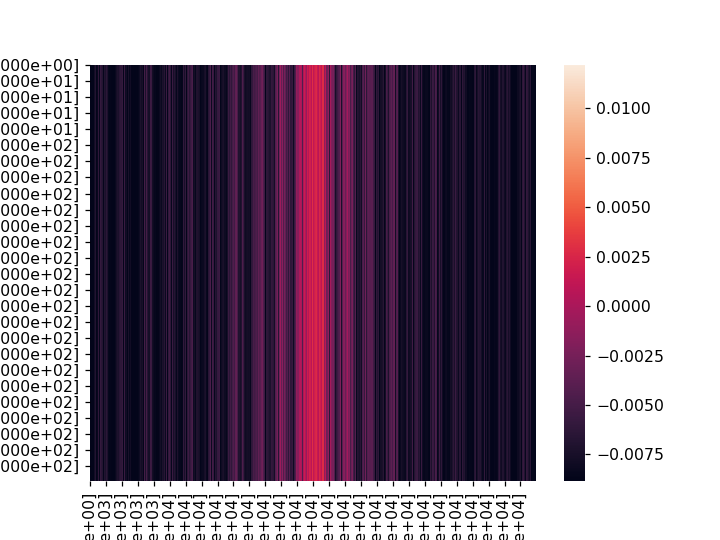

In [20]:
import seaborn as sns

def psd(x):
    return 2*np.log10(np.abs(x))/len(x)


plt.close("all")
sns.heatmap(df_scf.transform(psd))
plt.show()

In [14]:
## I still believe I have too many frequencies and need to reduce my data set down
# Test 1. lets treat the freqs as features and the alphas as observations. 
#
# Sparse Principal Components Analysis (SparsePCA). [concept is to filter freqs as much as possible]

def psd(x):
    return 2*np.log10(np.abs(x))/len(x)

from sklearn.decomposition import PCA

X = np.transpose(df_scf.transform(psd)) # analysis on SCF... dimensionality reduction 

pca = PCA(n_components=10, random_state=0)
pca.fit(X)

X_pca = pca.transform(X)
print(X_pca.shape)








(60000, 10)


In [15]:
print(pca.explained_variance_)
print(pca.components_)

[4.06632601e-03 5.07304628e-35 7.39753373e-37 4.15324685e-37
 1.81211300e-37 1.55020395e-37 8.88877483e-38 3.91895672e-38
 3.72548163e-38 3.06784604e-38]
[[ 0.0409616   0.0409616   0.0409616  ...  0.0409616   0.0409616
   0.0409616 ]
 [ 0.01327979  0.01069046  0.01561167 ... -0.02470189 -0.02577937
  -0.01205915]
 [-0.00133172 -0.05044069  0.00159351 ... -0.04846106  0.05236959
   0.01592414]
 ...
 [-0.01182906 -0.01017729  0.01689485 ... -0.15975061 -0.11965903
  -0.09040367]
 [ 0.05940867 -0.00146646 -0.05379862 ...  0.08006421  0.01335956
   0.05464303]
 [ 0.06140035 -0.0325228   0.03711657 ... -0.03899527 -0.0374314
  -0.01988912]]


In [16]:
print(np.dot(pca.components_[0], alpha ))

33079765.71863834


<IPython.core.display.Javascript object>


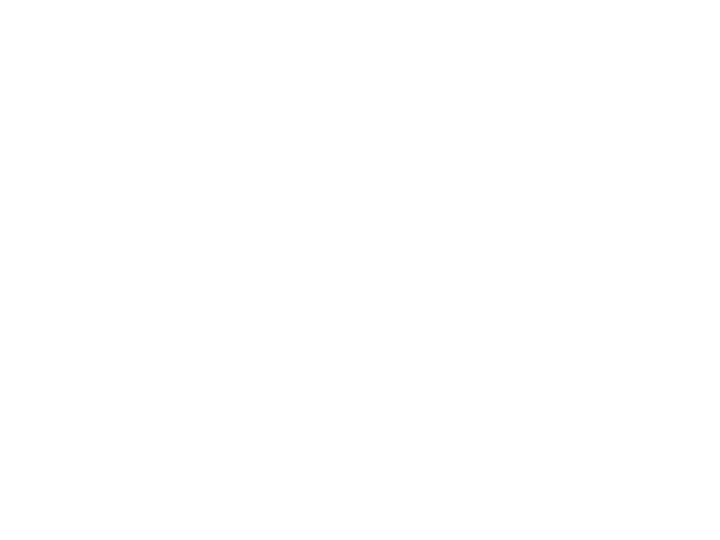

In [17]:
import seaborn as sns
df_pca = pd.DataFrame(X_pca)

plt.close("all")
sns.heatmap(df_pca)
plt.show()

<IPython.core.display.Javascript object>


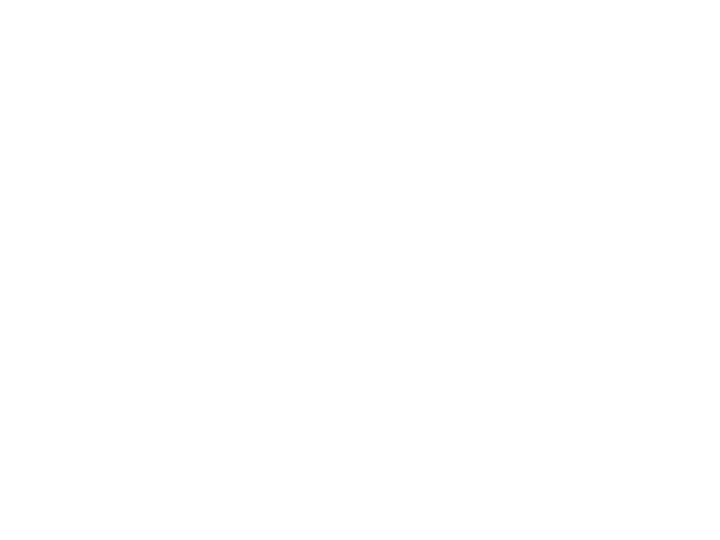

In [18]:
plt.close("all")
f(df['smooth_iq_encoded_message']).plot.line()
plt.show()

<IPython.core.display.Javascript object>


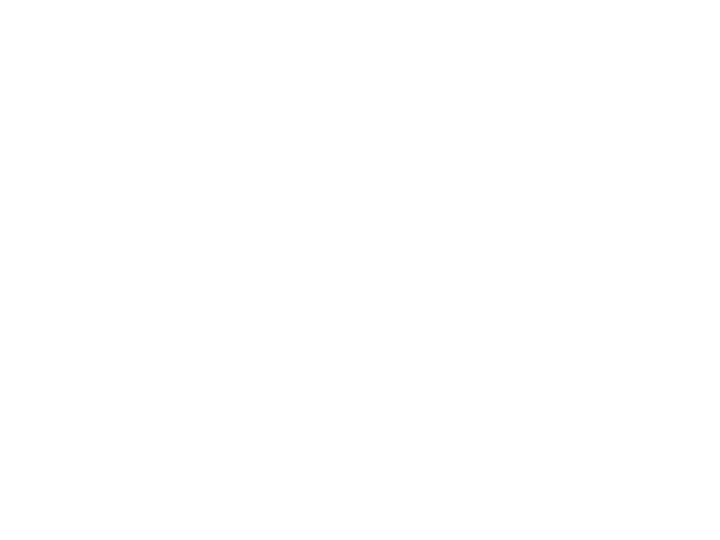

In [19]:
plt.close("all")
df_s["dim_reduced"] = df_pca[0]

np.exp(df_s["dim_reduced"]).plot.line()

plt.show()